# Basic Model

The objective of the basic model is to determine the utilities for each role when participating in the BTC-Parachain. The basic setup only includes a single round of interactions and makes several simplifying assumptions:

- Each role is represented as a single agent, i.e., the basic simulation does not differentiate between different user, vault, staked relayer, and keeper types.
- The BTC-Relay is always up-to-date and synchronized by staked relayers.
- There are no faults in the Parachain.
- All roles act honestly.
- The price oracle is correct and up-to-date.

The idea is to extend the basic model to more complex cases later on.

## Parameters

The simulation is based on several parameters that are defined in the BTC-Parachain (endogenous parameters) and that are external to the system and cannot be changed (exogenous parameters).

### Endogenous parameters

The BTC-Parachain is configured through several parameters:

- Vault Registry (https://interlay.gitlab.io/polkabtc-spec/spec/vaultregistry.html#constants)
    - Minimum Collateral Vault
    - Secure Collateral Threshold
    - Auction Collateral Threshold
    - Premium Redeem Threshold
    - Liquidation Collateral Threshold
- Staked Relayers (https://interlay.gitlab.io/polkabtc-spec/spec/staked-relayers.html#constants)
    - Staked Relayer Vote Threshold
    - Minimum Collateral Staked Relayer
- Issue (https://interlay.gitlab.io/polkabtc-spec/spec/issue.html#scalars)

    - Issue Period
    - Request Issue Gas (to be defined)
    - Execute Issue Gas (to be defined)
- Redeem (https://interlay.gitlab.io/polkabtc-spec/spec/redeem.html#scalars)
    - Redeem Period
    - Request Redeem Gas (to be defined)
    - Execute Redeem Gas (to be defined)
- Replace (https://interlay.gitlab.io/polkabtc-spec/spec/replace.html#scalars)
    
    - Replace Period
- BTC-Relay (https://interlay.gitlab.io/polkabtc-spec/btcrelay-spec/)
    - Store Block Header Gas
- Fee (https://interlay.gitlab.io/polkabtc-spec/spec/fee.html)
    - Vault Rewards
    - Staked Relayer Rewards
    - Collator Rewards
    - Maintainer Rewards
    - Issue Fee
    - Issue Griefing Collateral
    - Redeem Fee
    - Premium Redeem Fee
    - Auction Replace Fee
    - Punishment Fee
    - Replace Griefing COllateral
- SLA (https://interlay.gitlab.io/polkabtc-spec/spec/sla.html)
    - Vault SLA Target
    - Failed Redeem
    - Executed Issue
    - Submitted Issue Proof
    - Staked Relayer SLA Target
    - Block Submission
    - Correct Theft Report
    
    

### Exogenous parameters

We need to account for several factors outside the control of the Parachain.

- Parachain
    - Gas price in Planck
- Bitcoin
    - Satoshi per byte
    - OP_RETURN tx bytes (P2WPKH)
- Exchange Rates
    - Satoshi in Planck
    - Planck in Satoshi
    - Satoshi in USD (buy)
    - Satoshi in USD (sell)
    - Planck in USD (buy)
    - Planck in USD (sell) 


## Actions

Each role can perform a range of actions. An overview can be found in the official [specification](https://interlay.gitlab.io/polkabtc-spec/intro/architecture.html#interactions).

- User
    - Request issue: request to mint PolkaBTC for locking BTC with a vault
    - Transfer BTC: transfer BTC to a vault during the issue process
    - Execute issue: complete minting PolkaBTC through sending a BTC tx inclusion proof
    - Request redeem: request to redeem PolkaBTC for BTC
    - Cancel redeem: cancel a redeem request if a vault did not complete the request on time
- Vault
    - Lock collateral: lock DOT as collateral
    - Cancel issue: cancel an issue request if the user did not complete the request on time
    - Transfer BTC: transfer BTC to a user during the redeem process
    - Execute redeem: complete redeeming PolkaBTC through sending BTC tx inclusion proof
- Keeper
    - Locked collateral: lock DOT as collateral
    - Auction replace: replace a vault that is below the auction collateral threshold
- Staked relayer
    - Submit BTC block: submits the latest BTC block
 

## Basic Model

Considers a single step: users issue PolkaBTC with the vaults in the system. They decide how many PolkaBTC are being issued and how many BTC they issue per transaction.

Setting the environment variables.

#### Imports

In [1]:
# Packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Plot customization
sns.set_theme(style="ticks", color_codes=True)
sns.set_context("paper")
sns.set_style("whitegrid")
pd.options.display.float_format = "{:,.2f}".format

# PolkaBTC imports
from environment import Environment
from polkabtc import PolkaBTC
from agents import Agents

#### System Init

In [2]:
# init environment
env = Environment()

agents = Agents()
polkabtc = PolkaBTC()

# Init issued btc with 0 
btc_issued = 0

#### PolkaBTC Parameterization

In [3]:
# Set exchange rates
btc_in_usd = 58_360.17
dot_in_usd = 41.10
# feed in the current btc and dot prices
env.setCurrentExchangeRates(btc_in_usd, dot_in_usd)
# NOTE: the oracle in polkabtc needs to be manually updated as to simulate differences in the "true" exchange rate to the system exchange rate later on
polkabtc.oracle.setRates(env)

# Set transaction fees
polkadot_tx_fee = 452_088_000 # in Planck see https://github.com/interlay/btc-parachain/blob/master/crates/issue/src/default_weights.rs
sat_per_byte = 19 # bitcoin transaction fees per byte in Sat
# feed in transaction costs
env.setTransactionCosts(sat_per_byte, polkadot_tx_fee)


# set 0 griefing collateral and 0.5% issue fee
polkabtc.issue.setModel(
    griefing_collateral=0, 
    fee=0.005
)

# set the collateral thresholds
polkabtc.vault_registry.setThresholds(secure=1.5, auction=1.2, premium=1.3, liquidation=1.1)

# set distribution of issue fees among agents
polkabtc.fee_share.setIssue(
    vault=0.77, 
    relayer=0.03, 
    maintainer=0.2,
    collator=0
)

# Set average Issue request size
btc_per_transaction = 1

# Set total amount of BTC-backed assets issued per round
# 15.000 BTC = USD 875.402.550 (~8% of BTC locked on Ethereum on 8 April 2021)
new_btc_to_issue_per_round = 15000/12

# Set duration in rounds; "round" can be any time unit (day, week, month,...)
# here we assume 15.000 BTC being locked over a period of 12 months
rounds = 12

### Analysis

In [4]:
# init total fees pandas DataFrame
total_fees = agents.get_accumulated_fees_in_usd(env, btc_issued)

for i in range(rounds):
    btc_issued += new_btc_to_issue_per_round
    polkabtc.execute_issue(env, agents, new_btc_to_issue_per_round, btc_per_transaction)

    # get all fees in usd as a list sorted by user, vault, relayer, maintainer, collator
    # the fees are based on the exchange rates set in `env`
    fees = agents.get_accumulated_fees_in_usd(env, polkabtc.total_polkaBTC)
    total_fees = total_fees.append(fees, ignore_index=True)


#### Vaults

Since Vaults need to keep their collateral proportional to the locked BTC, their APY and earned interest is constant in this model. Note, the model assumes and ideal collateralization of exactly at the secure collateral threshold. This means, without any other tokens or subsidy, Vaults earn 0.26% APY.

In [5]:
print("PolkaBTC issued [BTC]: {}".format(btc_issued))
print("PolkaBTC issued [USD]: {}". format(env.btcToUsd(btc_issued)))
print("Fees Vault [USD]: \n{}".format(total_fees[total_fees["agents"] == "vault"]))

PolkaBTC issued [BTC]: 15000.0
PolkaBTC issued [USD]: 875402550.0
Fees Vault [USD]: 
    total_btc    locked_dot   locked_dot_usd agents  fees_abs_usd  \
1        0.00          0.00             0.00  vault          0.00   
6    1,250.00  2,662,416.51   109,425,318.75  vault    280,858.32   
11   2,500.00  5,324,833.03   218,850,637.50  vault    561,716.64   
16   3,750.00  7,987,249.54   328,275,956.25  vault    842,574.95   
21   5,000.00 10,649,666.06   437,701,275.00  vault  1,123,433.27   
26   6,250.00 13,312,082.57   547,126,593.75  vault  1,404,291.59   
31   7,500.00 15,974,499.09   656,551,912.50  vault  1,685,149.91   
36   8,750.00 18,636,915.60   765,977,231.25  vault  1,966,008.23   
41  10,000.00 21,299,332.12   875,402,550.00  vault  2,246,866.54   
46  11,250.00 23,961,748.63   984,827,868.75  vault  2,527,724.86   
51  12,500.00 26,624,165.15 1,094,253,187.50  vault  2,808,583.18   
56  13,750.00 29,286,581.66 1,203,678,506.25  vault  3,089,441.50   
61  15,000.00 31,9

#### Staked Relayers

Staked Relayers have a fixed size collateral in the current model. Hence, their earnings increase with the amount of PolkaBTC issued. It would be possible to require Staked Relayers to lock collateral in proportion to the amount of BTC locked. However, this would only be relevant if they would play a role in the governance of the chain. Since in the current iteration, Staked Relayers cannot vote on the state of the BTC-Parachain, their collateral should remain constant.

In [6]:
print("PolkaBTC issued [BTC]: {}".format(btc_issued))
print("PolkaBTC issued [USD]: {}". format(env.btcToUsd(btc_issued)))
print("Fees Relayer [USD]: \n{}".format(total_fees[total_fees["agents"] == "relayer"]))

PolkaBTC issued [BTC]: 15000.0
PolkaBTC issued [USD]: 875402550.0
Fees Relayer [USD]: 
    total_btc   locked_dot  locked_dot_usd   agents  fees_abs_usd  \
2        0.00 1,000,000.00   41,100,000.00  relayer          0.00   
7    1,250.00 1,000,000.00   41,100,000.00  relayer     10,942.53   
12   2,500.00 1,000,000.00   41,100,000.00  relayer     21,885.06   
17   3,750.00 1,000,000.00   41,100,000.00  relayer     32,827.60   
22   5,000.00 1,000,000.00   41,100,000.00  relayer     43,770.13   
27   6,250.00 1,000,000.00   41,100,000.00  relayer     54,712.66   
32   7,500.00 1,000,000.00   41,100,000.00  relayer     65,655.19   
37   8,750.00 1,000,000.00   41,100,000.00  relayer     76,597.72   
42  10,000.00 1,000,000.00   41,100,000.00  relayer     87,540.26   
47  11,250.00 1,000,000.00   41,100,000.00  relayer     98,482.79   
52  12,500.00 1,000,000.00   41,100,000.00  relayer    109,425.32   
57  13,750.00 1,000,000.00   41,100,000.00  relayer    120,367.85   
62  15,000.00 1,

#### Collators

Collators income increased with the total BTC locked. They do not have to provide collateral so an APY calculation is not really applicable.

In [7]:
print("PolkaBTC issued [BTC]: {}".format(btc_issued))
print("PolkaBTC issued [USD]: {}". format(env.btcToUsd(btc_issued)))
print("Fees Collator [USD]: \n{}".format(total_fees[total_fees["agents"] == "collator"]))

PolkaBTC issued [BTC]: 15000.0
PolkaBTC issued [USD]: 875402550.0
Fees Collator [USD]: 
    total_btc  locked_dot  locked_dot_usd    agents  fees_abs_usd  \
4        0.00   10,000.00      411,000.00  collator          0.00   
9    1,250.00   10,000.00      411,000.00  collator      4,645.20   
14   2,500.00   10,000.00      411,000.00  collator      9,290.41   
19   3,750.00   10,000.00      411,000.00  collator     13,935.61   
24   5,000.00   10,000.00      411,000.00  collator     18,580.82   
29   6,250.00   10,000.00      411,000.00  collator     23,226.02   
34   7,500.00   10,000.00      411,000.00  collator     27,871.23   
39   8,750.00   10,000.00      411,000.00  collator     32,516.43   
44  10,000.00   10,000.00      411,000.00  collator     37,161.63   
49  11,250.00   10,000.00      411,000.00  collator     41,806.84   
54  12,500.00   10,000.00      411,000.00  collator     46,452.04   
59  13,750.00   10,000.00      411,000.00  collator     51,097.25   
64  15,000.00  

### PolkaBTC Parameterization

The below figures are an illustration of the analysis above.

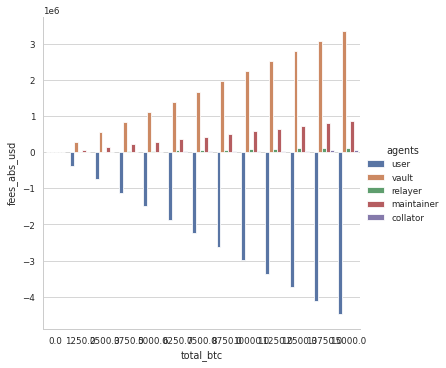

In [8]:
sns.catplot(kind="bar", x="total_btc", y="fees_abs_usd", hue="agents", data=total_fees)

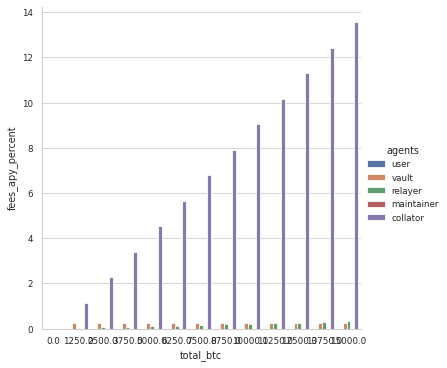

In [9]:
sns.catplot(kind="bar", x="total_btc", y="fees_apy_percent", hue="agents", data=total_fees)